In [2]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [3]:
#@title **Location** of the dataset
path =  "../data/LendingClub/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [5]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [7]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri
import credit_pipeline.evaluate as ev

from submodules.topsis_python import topsis as top

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

#Read Dataset

In [8]:
ls '../data/LendingClub/'

accepted_2007_to_2018Q4.csv  rejected_2007_to_2018Q4.csv


In [9]:
#@title Accepts
selected_columns = ["dti","addr_state", "fico_range_high", "fico_range_low", "loan_amnt", "emp_length", "loan_status"]

# Specify the number of rows to read (300,000 in this case)
num_rows = 80000

# Read only the specified columns and the first 300,000 samples
df_o = pd.read_csv(path+'accepted_2007_to_2018Q4.csv', usecols=selected_columns, nrows=num_rows)

In [10]:
#@title Rejects
selected_columns = ["Debt-To-Income Ratio","State", "Risk_Score", "Amount Requested", "Employment Length"]

# Specify the number of rows to read (300,000 in this case)
num_rows = 80000

# Read only the specified columns and the first 300,000 samples
df_r = pd.read_csv(path+'rejected_2007_to_2018Q4.csv', usecols=selected_columns, nrows=num_rows)

In [11]:
#rejected fix names
df_r["emp_length"] = df_r["Employment Length"]
df_r["addr_state"] = df_r["State"]
df_r["dti"] = df_r["Debt-To-Income Ratio"]
df_r["dti"] = pd.to_numeric(df_r['dti'].str.replace('%', ''))
df_r["loan_amnt"] = df_r["Amount Requested"]
df_r["risk_score"] = df_r["Risk_Score"]

#accepted fix names
df_o["risk_score"] = df_o.loc[:,["fico_range_high","fico_range_low"]].mean(axis=1)
df_o["TARGET"] = np.where((df_o.loan_status == 'Current') |
                        (df_o.loan_status == 'Fully Paid') |
                        (df_o.loan_status== "Issued") |
                        (df_o.loan_status == 'Does not meet the credit policy. Status:Fully Paid'), 0, 1)


In [12]:
df_o = df_o.drop(columns=["loan_status", "fico_range_low", "fico_range_high"])
df_r = df_r.drop(columns=["Amount Requested", "Employment Length", "State",
                   "Debt-To-Income Ratio", "Amount Requested","Risk_Score"])

In [13]:
#@title Create develoment train and test
# df_train, df_test = tr.create_train_test(df_o, seed=43)

In [14]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 420

print(seed_number)

420


#Params

In [15]:
params_dict = ri.params_dict

In [16]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

#<font color='orange'>Helper Functions</font>


#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [17]:
filepath = Path(os.path.join(ri_datasets_path,f'TN-{420}.joblib'))
datasets = joblib.load(filepath)

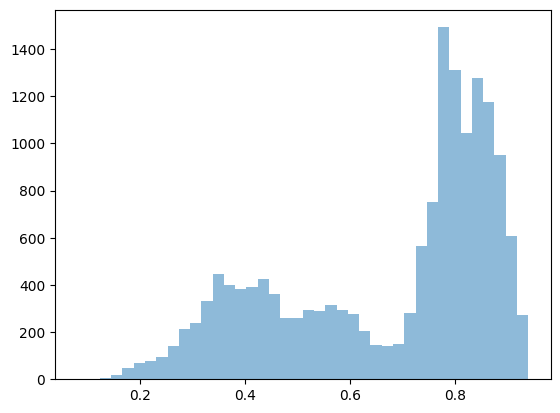

In [20]:
plt.hist(datasets['TN_1'].predict_proba(X_test_rej)[:,1]
         , bins=40, alpha=0.5, label='1', density=False)
plt.show()

In [17]:
# df_train = df_train.sample(frac=0.05)

In [19]:
N_splits=5  
kf = KFold(n_splits=N_splits)   #80-20 split for train-test
hist_dict = {}

for fold_number, (train_index, test_index) in enumerate(kf.split(df_o)):
    #diferent seed for each iteration
    seed_number = seed_number+fold_number

    df_train = df_o.iloc[train_index]
    df_test = df_o.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    # df_train, policy_model = ri.fit_policy(df_train)

    X_train = df_train.loc[:, df_train.columns != "TARGET"]
    X_test = df_test.loc[:, df_test.columns != "TARGET"]
    X_val = df_val.loc[:, df_val.columns != "TARGET"]
    y_train, y_test, y_val = df_train["TARGET"], df_test["TARGET"], df_val["TARGET"]

    X_train_acp, y_train_acp = X_train, y_train
    X_test_acp, y_test_acp = X_test, y_test
    X_val_acp, y_val_acp = X_val, y_val
    X_train_rej, X_test_rej = train_test_split(df_r, test_size=0.2, random_state=seed_number)
    
    # dex.get_shapes(X_train_acp, X_train_rej, X_test_acp, X_test_rej, X_val_acp, X_val_rej)

    # metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    # break
    # models_dict = {}

    # benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
    #                               LGBMClassifier(**params_dict['LightGBM_2']), do_EBE=True)
    # benchmark.fit(X_train_acp, y_train_acp)

    
    # models_dict['BM'] = benchmark

    # models_dict.update(
    #     ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
    # models_dict.update(
    #     ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
    # models_dict.update(
    #     ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    # models_dict.update(
    #     ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej,
    #                              X_val_acp, y_val_acp, iterations=50,p=0.18, seed=seed_number))
    
    # hist_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test_acp, 
    #                                            y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    # print(f'fold_number: {fold_number}')
    break

In [19]:
hist_dict[0]

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.639698,0.640363,0.638982,0.638088,0.613616,0.640381,0.626118,0.629306,0.626493
KS,0.212003,0.209956,0.211157,0.207485,0.166285,0.213020,0.186439,0.190010,0.191283
Balanced Accuracy,0.601242,0.604181,0.603179,0.602438,0.582008,0.603581,0.591262,0.592379,0.592264
Accuracy,0.552000,0.584313,0.576125,0.577750,0.522938,0.577000,0.588500,0.553000,0.567438
Precision,0.240833,0.248790,0.246495,0.246471,0.227231,0.246881,0.242963,0.236741,0.239266
Recall,0.678682,0.635427,0.645726,0.641263,0.674906,0.645383,0.595606,0.654308,0.631308
F1,0.355512,0.357578,0.356791,0.356081,0.339991,0.357143,0.345136,0.347683,0.347014
Approval Rate,0.084125,0.088688,0.000000,0.085938,0.000125,0.000000,0.000063,0.084500,0.000000
Kickout,0.000000,0.002881,0.019106,0.064026,0.000000,0.010463,-0.001592,0.332186,0.000000
KG,0.000000,44.000000,76.000000,91.000000,0.000000,44.000000,2.000000,497.000000,0.000000


In [20]:
mean_metrics = sum([hist_dict[i] for i in range(N_splits)])/N_splits
mean_metrics

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.634733,0.634696,0.634168,0.631908,0.609170,0.634705,0.628593,0.624965,0.629784
KS,0.195518,0.193886,0.193828,0.190358,0.156787,0.193934,0.187048,0.178858,0.187786
Balanced Accuracy,0.596096,0.595290,0.594861,0.594127,0.576955,0.595287,0.591885,0.588403,0.593062
Accuracy,0.571040,0.576393,0.569183,0.570727,0.540033,0.576537,0.559847,0.563860,0.569717
Precision,0.244862,0.245223,0.243728,0.243455,0.229667,0.245299,0.240456,0.239216,0.242781
Recall,0.635510,0.625291,0.635283,0.631184,0.635439,0.625111,0.642398,0.627376,0.630093
F1,0.353087,0.352117,0.351946,0.351336,0.337287,0.352140,0.349628,0.346275,0.350384
Approval Rate,0.022667,0.022580,0.022630,0.021127,0.023467,0.024193,0.025510,0.024070,0.031490
Kickout,0.000000,0.009957,0.018040,0.034506,0.000000,0.011967,-0.000012,0.367802,0.000000
KG,0.000000,52.200000,84.400000,153.600000,0.000000,45.600000,1.000000,1910.000000,0.000000


In [61]:
metric = hist_dict[0].loc[['Overall AUC','KS','Kickout']]

<Axes: >

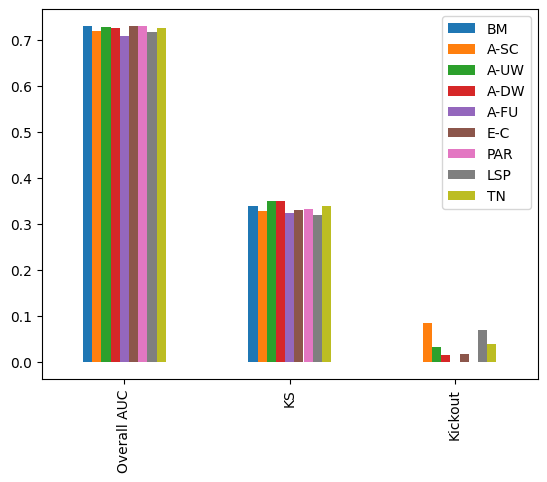

In [62]:
metric.plot.bar()

In [24]:
metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.01)

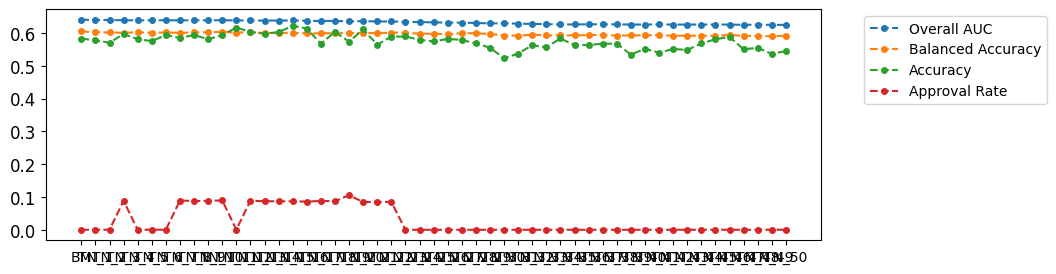

In [25]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

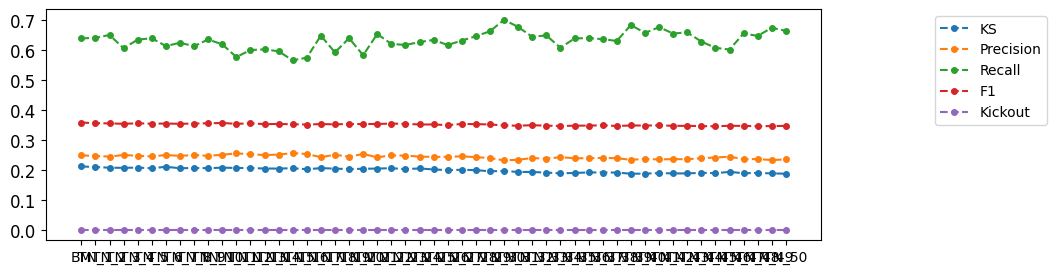

In [26]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()